# jPCA
This notebook is to reproduce jPCA functionality.

## Load in example data
For development, we will focus on just one condition. 

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from math import sqrt
from scipy import optimize

In [2]:
from scipy.io import loadmat

x = loadmat("../data/exampleData.mat")
x = x['Data'][0][0][0]
X = np.array(x)

## 1. Preprocess using PCA
There's another normalization preproc step but it is more data relevant than algo relevant so I will be leaving it out until later.

In [3]:
def pca_preproc(X, k):
    pca = PCA(n_components=k)
    pca.fit(X)
    X_red = pca.transform(X)
    return X_red, pca.explained_variance_ratio_

In [4]:
X.shape

(61, 218)

In [5]:
X_red, _ = pca_preproc(X, k=6)

In [12]:
X_red.shape

(61, 6)

## 2. Get Discrete Derivative of X_red
Need to save X minus final state as it is used in later steps.

In [6]:
X_prestate = X_red[:-1,]
dX = np.diff(X_red, axis=0)

In [7]:
print(X_prestate.shape)
print(dX.shape)

(60, 6)
(60, 6)


## 3. Solve for M_skew
The most important step

In [8]:
M0, _, _, _ = np.linalg.lstsq(X_prestate, dX, rcond=None)
M0_skew = .5*(M0 - M0.T)

In [9]:
M0.shape
print(M0_skew)

[[ 0.         -0.09082191  0.0214932  -0.02473931 -0.11288055  0.10015587]
 [ 0.09082191  0.          0.04595647  0.03914008  0.09296161 -0.01832981]
 [-0.0214932  -0.04595647  0.         -0.14769268  0.02202633  0.03025298]
 [ 0.02473931 -0.03914008  0.14769268  0.         -0.14714837  0.06671926]
 [ 0.11288055 -0.09296161 -0.02202633  0.14714837  0.          0.19425025]
 [-0.10015587  0.01832981 -0.03025298 -0.06671926 -0.19425025  0.        ]]


In [10]:
def mat2vec(mat):
    return mat.flatten('F')


def vec2mat(vec):
    shape = (int(sqrt(vec.size)), -1)
    return np.reshape(vec, shape, 'F')

In [11]:
m_skew = mat2vec(M0_skew)
print(M0_skew)

[[ 0.         -0.09082191  0.0214932  -0.02473931 -0.11288055  0.10015587]
 [ 0.09082191  0.          0.04595647  0.03914008  0.09296161 -0.01832981]
 [-0.0214932  -0.04595647  0.         -0.14769268  0.02202633  0.03025298]
 [ 0.02473931 -0.03914008  0.14769268  0.         -0.14714837  0.06671926]
 [ 0.11288055 -0.09296161 -0.02202633  0.14714837  0.          0.19425025]
 [-0.10015587  0.01832981 -0.03025298 -0.06671926 -0.19425025  0.        ]]


In [12]:
vec2mat(m_skew)

array([[ 0.        , -0.09082191,  0.0214932 , -0.02473931, -0.11288055,
         0.10015587],
       [ 0.09082191,  0.        ,  0.04595647,  0.03914008,  0.09296161,
        -0.01832981],
       [-0.0214932 , -0.04595647,  0.        , -0.14769268,  0.02202633,
         0.03025298],
       [ 0.02473931, -0.03914008,  0.14769268,  0.        , -0.14714837,
         0.06671926],
       [ 0.11288055, -0.09296161, -0.02202633,  0.14714837,  0.        ,
         0.19425025],
       [-0.10015587,  0.01832981, -0.03025298, -0.06671926, -0.19425025,
         0.        ]])

In [13]:
def optimize_skew(m_skew, X_prestate, dX):
    def objective(x, X_prestate, dX):
        f = np.linalg.norm(dX - X_prestate@vec2mat(x))
        print(f**2)
        return f**2
    def derivative(x, X_prestate, dX):
        D = dX - X_prestate@vec2mat(x)
        D = D.T @ X_prestate
        return 2*mat2vec(D - D.T)
    
    return optimize.minimize(objective, m_skew, jac = derivative, args=(X_prestate, dX))

In [14]:
result = optimize_skew(m_skew, X_prestate, dX)
print(result)
m_star = result.x

13801.905141781448
129179.66442183542
6799.093190283108
78768.74124039421
9085.16108631772
6729.116148707327
6682.759415764926
6651.977857036464
6684.171057530328
6649.322542447192
6653.803740357944
6649.246994675899
6649.178424929027
6649.143640207348
6649.109553896648
6648.994133817781
6648.874513565552
6648.756853422414
6648.349339082117
6648.077103103607
6647.806545356083
6646.81232618145
6645.683054869719
6644.542837308314
6639.988896331868
6621.8840007328245
6551.238311244518
6297.037839817151
5953.913803521631
4761.570276574062
3451.140218052275
2495.389555738806
2260.397388180093
      fun: 2260.397388180093
 hess_inv: array([[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 0.00000000e+00,  5.00000335e-01,  1.98235206e-09, ...,
         1.62733553e-12, -2.59128856e-13,  0.00000000e+00],
       [ 0.00000000e+00,  1.98235206e-09,  5.00000512e-01, ...,
         1.22568052e-10, -1.82695718e-11,  0.00000000

In [52]:
M_star = vec2mat(m_star)
print(M_star)
(np.isclose(M_star.T, -M_star)).all()

[[ 0.         -0.09093967  0.00462909 -0.0024506  -0.00979637  0.0002772 ]
 [ 0.09093967  0.          0.03637784  0.01857033  0.01674314 -0.00111542]
 [-0.00462909 -0.03637784  0.         -0.14404759  0.01828862  0.02939032]
 [ 0.0024506  -0.01857033  0.14404759  0.         -0.10559591  0.0274157 ]
 [ 0.00979637 -0.01674314 -0.01828862  0.10559591  0.          0.19456586]
 [-0.0002772   0.00111542 -0.02939032 -0.0274157  -0.19456586  0.        ]]


True

## Get components

In [66]:
evals, evecs = np.linalg.eig(M_star)
evecs = evecs.T

In [60]:
evals

array([-4.00043713e-13+0.23058957j, -4.00043713e-13-0.23058957j,
       -9.31998402e-13+0.08349076j, -9.31998402e-13-0.08349076j,
        1.33208028e-12+0.1480101j ,  1.33208028e-12-0.1480101j ])

In [61]:
np.imag(evals)

array([ 0.23058957, -0.23058957,  0.08349076, -0.08349076,  0.1480101 ,
       -0.1480101 ])

In [24]:
np.absolute(np.imag(evals))

array([0.23058957, 0.23058957, 0.08349076, 0.08349076, 0.1480101 ,
       0.1480101 ])

In [51]:
eval_j = np.imag(evals)
# negate to get descending order
sort_indices = np.argsort(-np.absolute(eval_j))
for evec in evecs:
    print(evec)

[ 0.00569288+0.05562876j  0.00569288-0.05562876j -0.67743378+0.j
 -0.67743378-0.j          0.18479485-0.06170388j  0.18479485+0.06170388j]
[ 0.05649337-0.02435237j  0.05649337+0.02435237j  0.00114418+0.63178732j
  0.00114418-0.63178732j -0.08982334-0.2983131j  -0.08982334+0.2983131j ]
[-0.20602622+0.00834137j -0.20602622-0.00834137j  0.17465813+0.110003j
  0.17465813-0.110003j    0.64410985+0.j          0.64410985-0.j        ]
[0.07264157+0.44550322j 0.07264157-0.44550322j 0.09004153-0.21667149j
 0.09004153+0.21667149j 0.03005386-0.49019674j 0.03005386+0.49019674j]
[0.66791704+0.j         0.66791704-0.j         0.04918575+0.02056974j
 0.04918575-0.02056974j 0.19679096+0.11098555j 0.19679096-0.11098555j]
[-0.05421547+0.54568279j -0.05421547-0.54568279j -0.00707007+0.20340716j
 -0.00707007-0.20340716j -0.05722953+0.39318099j -0.05722953-0.39318099j]


In [35]:
sort_indices

array([0, 1, 4, 5, 2, 3])

In [67]:
sorted_evecs = evecs[sort_indices]

In [68]:
sorted_evecs

array([[ 0.00569288+0.05562876j,  0.05649337-0.02435237j,
        -0.20602622+0.00834137j,  0.07264157+0.44550322j,
         0.66791704+0.j        , -0.05421547+0.54568279j],
       [ 0.00569288-0.05562876j,  0.05649337+0.02435237j,
        -0.20602622-0.00834137j,  0.07264157-0.44550322j,
         0.66791704-0.j        , -0.05421547-0.54568279j],
       [ 0.18479485-0.06170388j, -0.08982334-0.2983131j ,
         0.64410985+0.j        ,  0.03005386-0.49019674j,
         0.19679096+0.11098555j, -0.05722953+0.39318099j],
       [ 0.18479485+0.06170388j, -0.08982334+0.2983131j ,
         0.64410985-0.j        ,  0.03005386+0.49019674j,
         0.19679096-0.11098555j, -0.05722953-0.39318099j],
       [-0.67743378+0.j        ,  0.00114418+0.63178732j,
         0.17465813+0.110003j  ,  0.09004153-0.21667149j,
         0.04918575+0.02056974j, -0.00707007+0.20340716j],
       [-0.67743378-0.j        ,  0.00114418-0.63178732j,
         0.17465813-0.110003j  ,  0.09004153+0.21667149j,
         

In [82]:
def get_real_projection_vecs(conj_pair, evals=None):
    #TODO: make all vectors go counter clockwise
    # TODO: confusing rotation step?
    v1 = conj_pair[0] + conj_pair[1]
    v2 = (conj_pair[1] - conj_pair[0])*1j
    return (np.real(v1), np.real(v2))

In [83]:
conjugate_pairs = []
for i in range(len(sorted_evecs)//2):
    v1 = sorted_evecs[i]
    v2 = sorted_evecs[i + 1]
    conjugate_pairs.append((v1, v2))

In [84]:
conjugate_pairs[0]

(array([ 0.00569288+0.05562876j,  0.05649337-0.02435237j,
        -0.20602622+0.00834137j,  0.07264157+0.44550322j,
         0.66791704+0.j        , -0.05421547+0.54568279j]),
 array([ 0.00569288-0.05562876j,  0.05649337+0.02435237j,
        -0.20602622-0.00834137j,  0.07264157-0.44550322j,
         0.66791704-0.j        , -0.05421547-0.54568279j]))

In [89]:
jpc = np.array(get_real_projection_vecs(conjugate_pairs[0]))

In [90]:
jpc.shape

(2, 6)

## Plotting projections to see if this works

In [92]:
proj = X_red@jpc.T

In [94]:
x = proj[:, 0]
y = proj[:, 1]

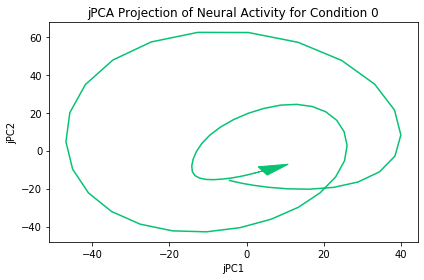

In [110]:
plt.plot(x, y, color="#06c273")
plt.title("jPCA Projection of Neural Activity for Condition 0")
plt.xlabel("jPC1")
plt.ylabel("jPC2")
plt.arrow(x[-1], y[-1], x[-1] - x[-2], y[-1] - y[-2], head_width=5, color="#06c273")
plt.tight_layout()
plt.savefig("jpca_condition0_plot.pdf")
plt.show()